# EDA for NYC Taxi trip duration data
#### Data Information
 + id - a unique identifier for each trip
 + vendor_id - a code indicating the provider associated with the trip record
 + pickup_datetime - date and time when the meter was engaged
 + dropoff_datetime - date and time when the meter was disengaged
 + passenger_count - the number of passengers in the vehicle (driver entered value)
 + pickup_longitude - the longitude where the meter was engaged
 + pickup_latitude - the latitude where the meter was engaged
 + dropoff_longitude - the longitude where the meter was disengaged
 + dropoff_latitude - the latitude where the meter was disengaged
 + store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
 + trip_duration - duration of the trip in seconds

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sin, cos, sqrt, atan2, radians

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train set', train.shape)
print('Test set', test.shape)

Train set (1458644, 11)
Test set (625134, 9)


In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# datetime function
def time_feats(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    dataset['dropoff_datetime'] = pd.to_datetime(dataset['dropoff_datetime'])

    dataset['pickup_hour'] = dataset['pickup_datetime'].dt.hour
    dataset['dropoff_hour'] = dataset['dropoff_datetime'].dt.hour
    dataset['pickup_weekday'] = dataset['pickup_datetime'].dt.weekday
    dataset['dropoff_weekday'] = dataset['dropoff_datetime'].dt.weekday
    return dataset

train = time_feats(train)

In [5]:
# trip distance
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

train['trip_distance'] = train.apply(lambda x: calculateDistance(x), axis = 1)

In [6]:
train['speed'] = train['trip_distance']/(train['trip_duration']/3600)

In [7]:
train.drop(['id', 'vendor_id'], axis = 1, inplace = True)

## 1. Target: trip duration
 + Target variable(trip duration) is highly skewed. --> Log Transformation
 + 너무 운행시간이 긴 값들이 outlier 일수도?

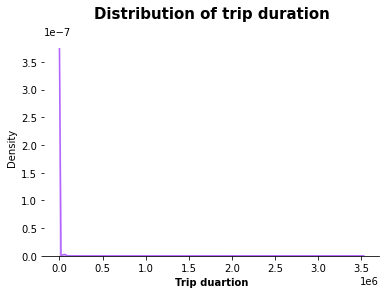

In [8]:
ax = sns.distplot(train['trip_duration'], color = '#b366ff', fit_kws={"color":"#b366ff"}, hist = False)

l = ax.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.fill_between(x,y, color = '#b366ff', alpha = 0.3)
plt.title('Distribution of trip duration', fontsize = 15, fontweight = 'bold', pad = 20)
plt.xlabel('Trip duartion', fontweight = 'bold')
plt.show()

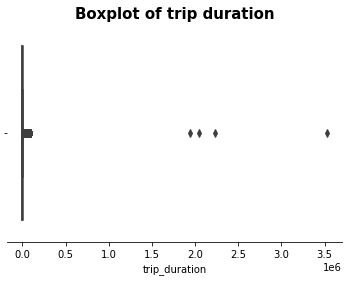

In [9]:
# outlier 확인
ax = sns.boxplot(train['trip_duration'], orient = 'v')
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
plt.title('Boxplot of trip duration', fontsize = 15, fontweight = 'bold')
plt.show()

### Outliers
위의 density plot과 box plot을 보면 알 수 있듯이, target 변수인 trip duration에는 몇몇 outlier가 존재한다. 이 값들의 경우, 비상식적으로 택시 이동 시간이 길다. 따라서 해당 값들을 제거한다.
 + pickup_datetime, dropoff_datetime 참고

In [10]:
# outlier 
train[train['trip_duration']>1500000]

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_weekday,dropoff_weekday,trip_distance,speed
355003,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,0,11,1,2,20.154989,0.037406
680594,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,22,15,5,1,5.984365,0.010511
924150,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,6,1,1,6,1.635641,0.002643
978383,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,22,18,5,4,19.906909,0.020323


In [11]:
# outlier 제거
train = train[train['trip_duration'] < 1500000]
print(train.shape)

(1458640, 15)


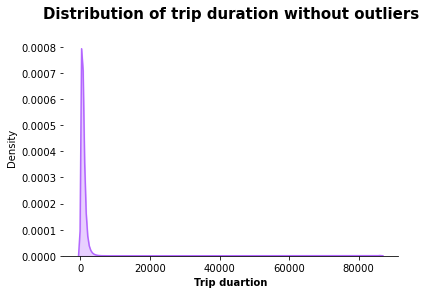

In [12]:
ax = sns.distplot(train['trip_duration'], color = '#b366ff', fit_kws={"color":"#b366ff"}, hist = False)

l = ax.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.fill_between(x,y, color = '#b366ff', alpha = 0.3)
plt.title('Distribution of trip duration without outliers', fontsize = 15, fontweight = 'bold', pad = 20)
plt.xlabel('Trip duartion', fontweight = 'bold')
plt.show()

## 2. Pickup and Dropoff hours/weekdays
Pickup과 Dropoff 모두 저녁과 밤 시간대에 가장 빈번하게 일어나며, 새벽 시간대(0시~5시)에 가장 택시 이동이 적다.
택시의 속도는 혼잡할수록 느려지는 경향을 보인다.

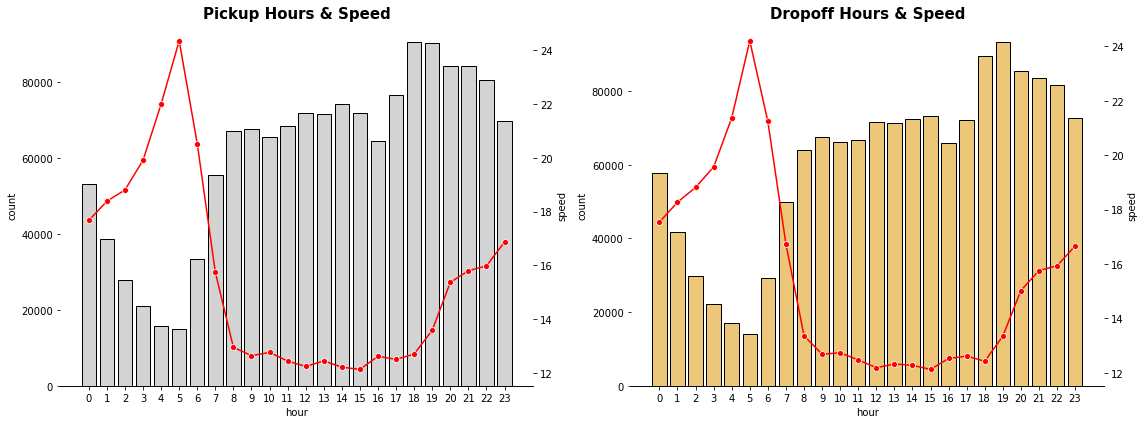

In [13]:
# hours
pickup = train['pickup_hour'].value_counts().reset_index().rename(columns = {'index': 'hour', 'pickup_hour': 'count'})
pickup = pickup.sort_values(by = 'hour')
dropoff = train['dropoff_hour'].value_counts().reset_index().rename(columns = {'index': 'hour', 'dropoff_hour': 'count'})
dropoff = dropoff.sort_values(by = 'hour')


plt.figure(figsize = (16, 6))
ax1 = plt.subplot(1, 2, 1); ax2 = plt.subplot(1, 2, 2)
ax1_2=ax1.twinx(); ax2_2 = ax2.twinx()

sns.barplot(x = pickup['hour'], y = pickup['count'], color = 'lightgrey', edgecolor = 'black', ax = ax1)
pick = train.groupby('pickup_hour')['speed'].mean().reset_index()
sns.lineplot(x = pick['pickup_hour'], y = pick['speed'], ax = ax1_2, marker = 'o', color = 'red')
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax1_2.spines[s].set_visible(False)
ax1.set_title('Pickup Hours & Speed', fontsize = 15, fontweight = 'bold')

sns.barplot(x = dropoff['hour'], y = dropoff['count'], color = '#ffcc66',  edgecolor = 'black', ax = ax2)
pick = train.groupby('dropoff_hour')['speed'].mean().reset_index()
sns.lineplot(x = pick['dropoff_hour'], y = pick['speed'], ax = ax2_2, marker = 'o', color = 'red')
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
    ax2_2.spines[s].set_visible(False)
ax2.set_title('Dropoff Hours & Speed', fontsize = 15, fontweight = 'bold')

plt.tight_layout()
plt.show()

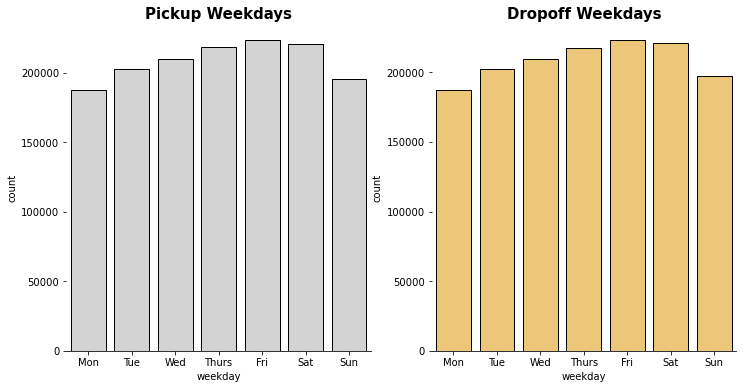

In [14]:
# weekdays
pickup = train['pickup_weekday'].value_counts().reset_index().rename(columns = {'index': 'weekday', 'pickup_weekday': 'count'})
pickup = pickup.sort_values(by = 'weekday')
dropoff = train['dropoff_weekday'].value_counts().reset_index().rename(columns = {'index': 'weekday', 'dropoff_weekday': 'count'})
dropoff = dropoff.sort_values(by = 'weekday')


plt.figure(figsize = (12, 6))
ax1 = plt.subplot(1, 2, 1); ax2 = plt.subplot(1, 2, 2)
sns.barplot(x = pickup['weekday'], y = pickup['count'], color = 'lightgrey', edgecolor = 'black', ax = ax1)
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.set_title('Pickup Weekdays', fontsize = 15, fontweight = 'bold')

sns.barplot(x = dropoff['weekday'], y = dropoff['count'], color = '#ffcc66',  edgecolor = 'black', ax = ax2)
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.set_title('Dropoff Weekdays', fontsize = 15, fontweight = 'bold')

plt.show()

## 3. Pickup & Dropoff locations
주로 뉴욕시 맨해튼 주변에서 택시 pickup, dropoff이 많이 이루어진다.

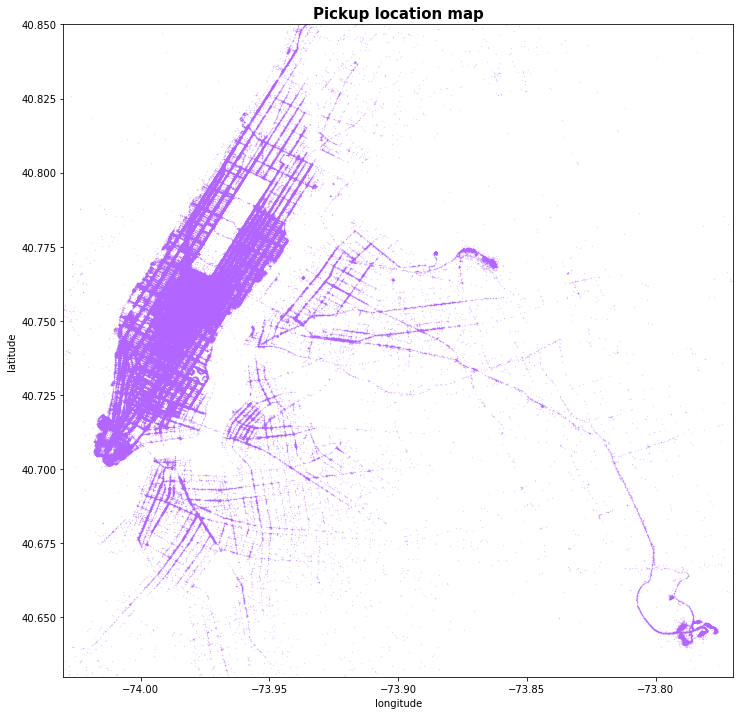

In [15]:
plt.figure(figsize=(12,12))
plt.xlim([-74.03, -73.77]); plt.ylim([40.63, 40.85])
plt.plot(train['pickup_longitude'].values,train['pickup_latitude'].values, '.',color = '#b366ff',alpha=0.5,markersize=0.4)
plt.title('Pickup location map', fontsize = 15, fontweight = 'bold'); plt.xlabel('longitude');plt.ylabel('latitude')
plt.show()

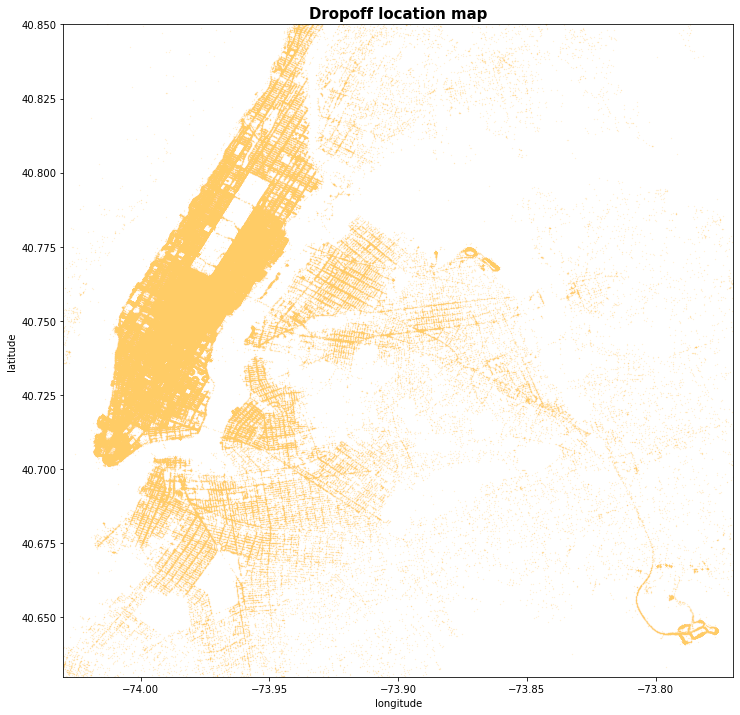

In [16]:
plt.figure(figsize=(12,12))
plt.xlim([-74.03, -73.77]); plt.ylim([40.63, 40.85])
plt.plot(train['dropoff_longitude'].values,train['dropoff_latitude'].values, '.',color='#ffcc66',alpha=0.5,markersize=0.4)
plt.title('Dropoff location map', fontsize = 15, fontweight = 'bold');plt.xlabel('longitude');plt.ylabel('latitude')
plt.show()

### 추가: store_and_fwd_flg 변수
해당 변수는 Y와 N으로 이루어진 범주형 변수인데, 각 범주에서 trip duartion의 분포 차이가 거의 없으므로 모델링에 유의미한 영향을 주는 변수는 아닐 것으로 예상된다.

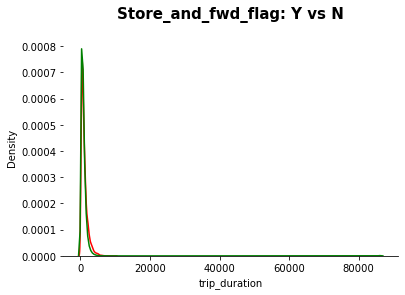

In [17]:
ax = plt.subplot(1,1,1)
sns.kdeplot(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'], color = 'red')
sns.kdeplot(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'], color = 'green')
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
plt.title("Store_and_fwd_flag: Y vs N", fontsize = 15, pad = 20, fontweight = 'bold')
plt.show()